In [1]:
from astropy.io import fits
from astropy.table import Table,join
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
## DATA ##
## I'm combining fastphot,fastspect, and ztile to make sure I use the same data everywhere ##

zall_path = "/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv1-bright-cumulative.fits"
data1 = Table.read(zall_path,hdu=1)
needed1 = ["TARGETID", "BGS_TARGET", "SPECTYPE", "DELTACHI2", "Z", "ZWARN", "FIBER", "PETAL_LOC", "TILEID"]

fastspec_path = "/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/catalogs/fastspec-fuji-sv1-bright.fits"
data2 = Table.read(fastspec_path,hdu=1)
data2.rename_column('CONTINUUM_COEFF', 'CONTINUUM_COEFF_FASTSPEC')
data2.rename_column('CONTINUUM_AV', 'CONTINUUM_AV_FASTSPEC')

needed2 = ["TARGETID", "OII_3726_EW", "OII_3729_EW", "HGAMMA_EW", "HBETA_EW", "OIII_4959_EW", "OIII_5007_EW", "NII_6548_EW", "HALPHA_EW", "NII_6584_EW", "SII_6716_EW", "SII_6731_EW",\
           "FLUX_SYNTH_G", "FLUX_SYNTH_R", "FLUX_SYNTH_Z", 'CONTINUUM_COEFF_FASTSPEC', 'CONTINUUM_AV_FASTSPEC',\
           "OII_3726_EW_IVAR", "OII_3729_EW_IVAR", "HGAMMA_EW_IVAR", "HBETA_EW_IVAR", "OIII_4959_EW_IVAR", "OIII_5007_EW_IVAR", "NII_6548_EW_IVAR", "HALPHA_EW_IVAR", "NII_6584_EW_IVAR",\
           "SII_6716_EW_IVAR", "SII_6731_EW_IVAR"]


fastphot_path = "/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/catalogs/fastphot-fuji-sv1-bright.fits"
data3 = Table.read(fastphot_path,hdu=1)
data3.rename_column('CONTINUUM_COEFF', 'CONTINUUM_COEFF_FASTPHOT')
data3.rename_column('CONTINUUM_AV', 'CONTINUUM_AV_FASTPHOT')

needed3 = ["TARGETID", "ABSMAG_SDSS_U", "ABSMAG_SDSS_G", "ABSMAG_SDSS_R", "ABSMAG_SDSS_I", "ABSMAG_SDSS_Z", "ABSMAG_W1", 'CONTINUUM_COEFF_FASTPHOT', 'CONTINUUM_AV_FASTPHOT']

data4 = join(data1[needed1], data2[needed2], keys="TARGETID")
data = join(data4, data3[needed3], keys="TARGETID")

N=len(data['TARGETID'])

## Adding the sum of OII doublets to use them as a single line
data.add_column(data["OII_3726_EW"]+data["OII_3729_EW"], name='OII_DOUBLET_EW')
data.add_column(1/(data["OII_3726_EW_IVAR"]+data["OII_3729_EW_IVAR"]), name='OII_DOUBLET_EW_IVAR')

/tmp/ipykernel_32535/2565242007.py:22: RuntimeWarning: divide by zero encountered in true_divide
  data.add_column(1/(1/data["OII_3726_EW_IVAR"]+1/data["OII_3729_EW_IVAR"]),name='OII_DOUBLET_EW_IVAR')


In [3]:
## Selecting data and doing LLR to predict lines ##
lines = ["OII_DOUBLET_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW","HALPHA_EW"\
        ,"NII_6584_EW","SII_6716_EW","SII_6731_EW"]

magnitude_names = ["ABSMAG_SDSS_U","ABSMAG_SDSS_G","ABSMAG_SDSS_R","ABSMAG_SDSS_I","ABSMAG_SDSS_Z"]

N = len(data["TARGETID"])
snr_cut = 1 # signal to noise ratio cut


# calculating snr for all lines
snr_all = np.zeros([N,len(lines)])
snr_all[:,0] = data[lines[0]]*np.sqrt(data[lines[0]+"_IVAR"])

for i in range(1,len(lines)):
    snr_all[:,i] = data[lines[i]]*np.sqrt(data[lines[i]+"_IVAR"])

select_pos = snr_all[:,6]>=snr_cut
select_neg = snr_all[:,6]<snr_cut

y_all = np.zeros(N)
y_all[select_pos] = 1


n=25*10**3 # number of data points I want to use out of N

795492
293551


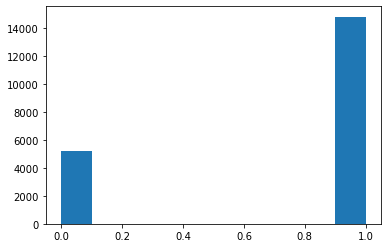

In [4]:
plt.hist(y_all[:n])
print(len(np.where(select_pos)[0]))
print(len(np.where(select_neg)[0]))

In [6]:
# which model
m=4

# calculating minimum redshift to have de-redshifted wavelengths be in the interval 3400,7000 A

w1 = 3400
w_min = 3600
z_min = w_min/w1-1

select = (data["SPECTYPE"]=="GALAXY")*(data["DELTACHI2"]>=25)*(data["Z"]>z_min)*(data["Z"]<0.3)*(data["ZWARN"]==0)
target_pos = np.where(select)[0][:n]

magnitudes_s = data[magnitude_names][target_pos]  
magnitudes = np.zeros([n,len(magnitude_names)])
for j in range(len(magnitude_names)):
    magnitudes[:,j] = magnitudes_s[magnitude_names[j]][:n]

# Getting features as colors and regularizing them    
#ones=np.ones([n,1])
scalar = StandardScaler()
x = np.zeros([n,len(magnitude_names)-1])
for i in range(n):
    for j in range(len(magnitude_names)-1):
        x[i,j] = magnitudes[i,j]-magnitudes[i,j+1]
x = scalar.fit_transform(x)
        
#x=np.concatenate((ones,x),axis=1)

y = y_all[target_pos]

N_cv = 10
x_split = np.split(x, N_cv)
y_split = np.split(y, N_cv)

y_pred_all = []
y_valid_all = []
count_all = []
for i in range(N_cv):
    x_valid=x_split[i]
    y_valid=y_split[i]
    x_to_combine=[]
    y_to_combine=[]
    for j in range(N_cv):
        if j!=i:
            x_to_combine.append(x_split[j])
            y_to_combine.append(y_split[j])
    x_train=np.concatenate(tuple(x_to_combine),axis=0)
    y_train=np.concatenate(tuple(y_to_combine),axis=0)
    if m==0:
        y_fit,zeros=LLR.LLR(x_valid, x_train, y_train, 100, 'inverse_distance')
    if m==1:
        model=RandomForestRegressor(n_estimators=200)
        model.fit(x_train, y_train)
        y_fit=model.predict(x_valid)
    if m==2:
        model=GradientBoostingRegressor(n_estimators=100)
        model.fit(x_train, y_train)
        y_fit=model.predict(x_valid)
    if m==3:
        model=xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
        model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_valid,y_valid)], verbose=False)
        y_fit=model.predict(x_valid)
        print(model.best_ntree_limit)
    if m==4:
        model_input = layers.Input(shape=x.shape[1])
        h1 = layers.Dense(units=100, kernel_initializer="he_normal")(model_input)
        a1 = layers.PReLU()(h1)
        h2 = layers.Dense(units=100, kernel_initializer="he_normal")(a1)
        a2 = layers.PReLU()(h2)
        h3 = layers.Dense(units=100, kernel_initializer="he_normal")(a2)
        a3 = layers.PReLU()(h3)
        output_layer = layers.Dense(1, activation='linear')(a3)
        model=keras.models.Model(inputs=model_input, outputs=output_layer)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics='mse')

        n_epochs = 100
        batch_size = 100
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_valid, y_valid))
        y_fit = model.predict(x_valid)

    if m==1:
        model=RandomForestClassifier()
        model.fit(x_train,y_train)
        y_pred=model.predict(x_valid)
        
    if m==4:
        model = keras.Sequential([
            layers.Dense(4, activation='relu', input_dim=x.shape[1]),
            layers.Dense(4, activation='relu'),    
            layers.Dense(1, activation='sigmoid'),
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy']) 
        model.fit(x_train, y_train, validation_data=(x_valid,y_valid), batch_size=100)
        y_pred=model.predict(x_valid).reshape(len(x_valid))

    y_pred_all.append(y_pred)
    y_valid_all.append(y_valid)
    count=len(np.where(y_pred==y_valid)[0])
    count_all.append(count/len(y_valid))
   
print(count_all)

2022-08-08 17:27:25.243289: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-08 17:27:25.243598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 17:27:25.246252: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
2022-08-08 17:27:25.329113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-08 17:27:25.348160: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300100000 Hz


180/180 [==============================] - 1s 3ms/step - loss: 0.6596 - binary_accuracy: 0.6849 - val_loss: 0.5297 - val_binary_accuracy: 0.7940
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


(array([ 86., 170., 195., 988., 355., 112.,  58.,  23.,  11.,   2.]),
 array([0.44063064, 0.48364866, 0.52666664, 0.5696846 , 0.6127026 ,
        0.65572065, 0.69873863, 0.7417566 , 0.78477466, 0.82779264,
        0.8708106 ], dtype=float32),
 <BarContainer object of 10 artists>)

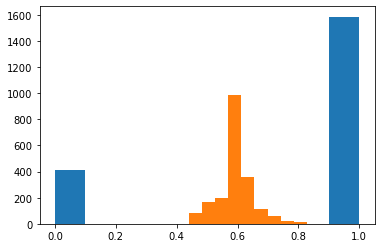

In [7]:
plt.figure(1)
plt.hist(y_valid_all[0])
plt.hist(y_pred_all[0])


In [ ]:
np.where(y_pred!=y_valid)

In [ ]:
i=1064
print(y_pred[i])
print(y_valid[i])